In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, RobustScaler, MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, precision_recall_curve, roc_curve, roc_auc_score
import numpy as np
from pprint import pprint

In [43]:
incomes = pd.read_csv('income_evaluation.csv')
incomes.head()
incomes.rename(columns= lambda x: x.strip(), inplace=True)

In [44]:
incomes.describe().applymap(lambda x: f"{x:0.1f}")

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.0,32561.0,32561.0,32561.0,32561.0,32561.0
mean,38.6,189778.4,10.1,1077.6,87.3,40.4
std,13.6,105550.0,2.6,7385.3,403.0,12.3
min,17.0,12285.0,1.0,0.0,0.0,1.0
25%,28.0,117827.0,9.0,0.0,0.0,40.0
50%,37.0,178356.0,10.0,0.0,0.0,40.0
75%,48.0,237051.0,12.0,0.0,0.0,45.0
max,90.0,1484705.0,16.0,99999.0,4356.0,99.0


In [45]:
incomes.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

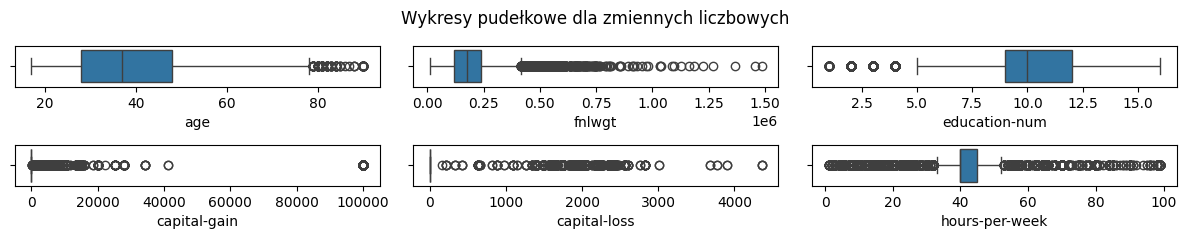

In [46]:
numeric_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

plt.figure(figsize=(12, 6))

for i, column in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), len(numeric_cols)//2, i)
    sns.boxplot(x=incomes[column])

plt.suptitle('Wykresy pudełkowe dla zmiennych liczbowych')
plt.tight_layout()
plt.show()

In [47]:
incomes = incomes.rename(columns=lambda x: x.strip())
categories = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']
incomes[categories] = incomes[categories].astype("category")
incomes = incomes.applymap(lambda x: x.strip() if not isinstance(x, int) else x)

In [48]:
for column in categories:
    print(column, set(incomes[column]))

workclass {'Without-pay', 'Federal-gov', '?', 'Private', 'State-gov', 'Local-gov', 'Self-emp-not-inc', 'Never-worked', 'Self-emp-inc'}
education {'7th-8th', 'Bachelors', 'Some-college', 'Assoc-acdm', '10th', '1st-4th', 'Masters', 'Prof-school', 'Doctorate', '11th', '12th', '5th-6th', '9th', 'Assoc-voc', 'HS-grad', 'Preschool'}
marital-status {'Widowed', 'Married-spouse-absent', 'Married-civ-spouse', 'Never-married', 'Divorced', 'Married-AF-spouse', 'Separated'}
occupation {'Craft-repair', '?', 'Other-service', 'Exec-managerial', 'Farming-fishing', 'Armed-Forces', 'Priv-house-serv', 'Adm-clerical', 'Sales', 'Tech-support', 'Machine-op-inspct', 'Protective-serv', 'Transport-moving', 'Handlers-cleaners', 'Prof-specialty'}
relationship {'Husband', 'Own-child', 'Not-in-family', 'Other-relative', 'Wife', 'Unmarried'}
race {'Other', 'Amer-Indian-Eskimo', 'White', 'Black', 'Asian-Pac-Islander'}
sex {'Female', 'Male'}
native-country {'Taiwan', 'Canada', 'Philippines', 'El-Salvador', 'Haiti', 'S

In [49]:
for column in ['workclass', 'occupation', 'native-country']:
    incomes[column].replace("?", np.NaN, inplace=True)
    incomes[column] = incomes[column].fillna(incomes[column].mode()[0])

In [50]:
incomes['additional_money'] = incomes['capital-gain'] - incomes['capital-loss']
incomes = incomes.drop(columns=['capital-gain', 'capital-loss', 'education-num', 'relationship'], axis=1)
incomes.head()

,age,workclass,fnlwgt,education,marital-status,occupation,race,sex,hours-per-week,native-country,income,additional_money
0,39,State-gov,77516,Bachelors,Never-married,Adm-clerical,White,Male,40,United-States,<=50K,2174
1,50,Self-emp-not-inc,83311,Bachelors,Married-civ-spouse,Exec-managerial,White,Male,13,United-States,<=50K,0
2,38,Private,215646,HS-grad,Divorced,Handlers-cleaners,White,Male,40,United-States,<=50K,0
3,53,Private,234721,11th,Married-civ-spouse,Handlers-cleaners,Black,Male,40,United-States,<=50K,0
4,28,Private,338409,Bachelors,Married-civ-spouse,Prof-specialty,Black,Female,40,Cuba,<=50K,0


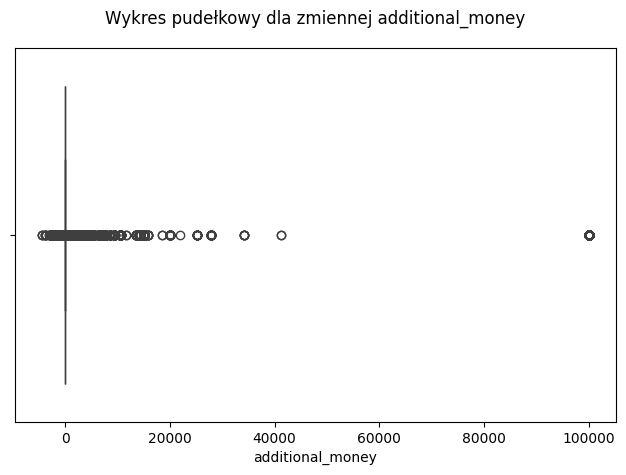

In [51]:
sns.boxplot(x=incomes['additional_money'])

plt.suptitle('Wykres pudełkowy dla zmiennej additional_money')
plt.tight_layout()
plt.show()

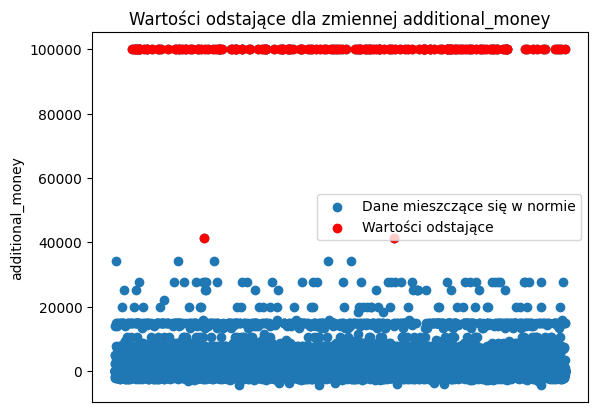

In [52]:
# Zaznacz outliery dla zmiennej 'additional_money' na wykresie punktowym
plt.clf()
plt.scatter(incomes.index, incomes['additional_money'], label='Dane mieszczące się w normie')
plt.scatter(incomes[incomes['additional_money'] > 40000].index, incomes[incomes['additional_money'] > 40000]['additional_money'], color='red', label='Wartości odstające')
# Dostosuj etykiety osi
plt.xticks([])
plt.ylabel('additional_money')
# Dodaj tytuł wykresu
plt.title('Wartości odstające dla zmiennej additional_money')
# Dodaj legendę
plt.legend()
# Wyświetl wykres

plt.show()

In [53]:
# Przycięcie wartości odstających dla zmiennej additional_money
incomes['additional_money'] = np.where(incomes['additional_money'] > 40000, 40000, incomes['additional_money'])

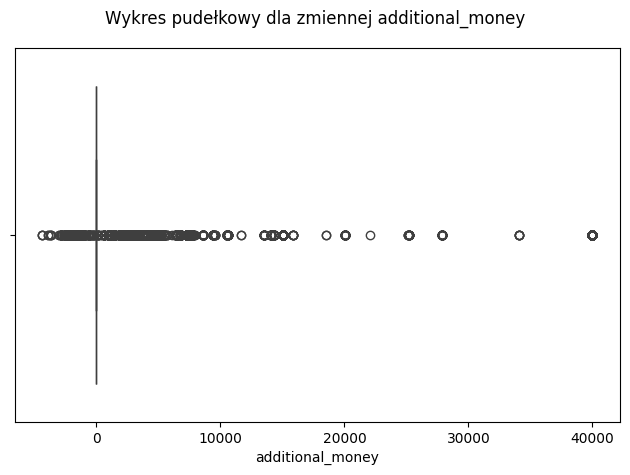

In [62]:
sns.boxplot(x=incomes['additional_money'])

plt.suptitle('Wykres pudełkowy dla zmiennej additional_money')
plt.tight_layout()
plt.show()

income  sex   
<=50K   Female    38.802589
        Male      61.197411
>50K    Female    15.036347
        Male      84.963653
dtype: float64


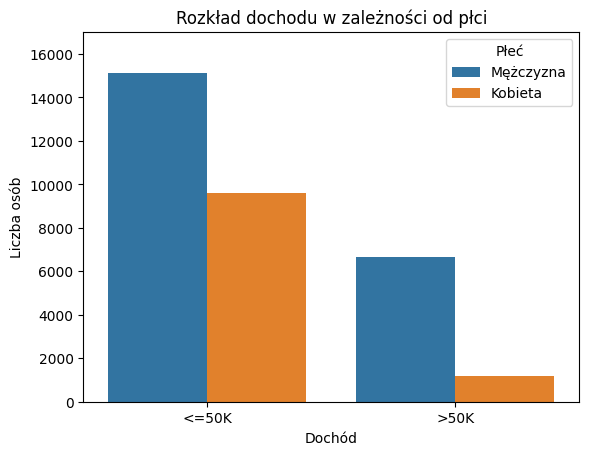

In [55]:
ctplot = sns.countplot(data=incomes, x='income', hue='sex')

ctplot.set_xlabel('Dochód')
ctplot.set_ylabel('Liczba osób')
ctplot.set_title('Rozkład dochodu w zależności od płci')
ctplot.set_ylim(0, 17000)

ctplot.legend(title='Płeć', labels=['Mężczyzna', 'Kobieta'])
occurrences = incomes.groupby(['income', 'sex']).size()
percentages = occurrences.groupby(level=0, group_keys=False).apply(lambda x: 100 * x / float(x.sum()))

print(percentages)

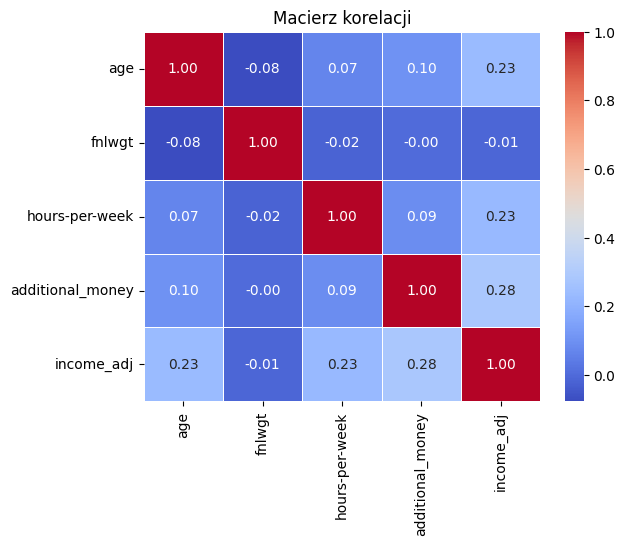

In [56]:
def adjust_income(income: str):
  if income == '<=50K':
    return 0
  elif income == '>50K':
    return 1
  else:
      return 0

incomes['income_adj'] = incomes['income'].apply(adjust_income)
numeric_cols = incomes.select_dtypes('number').columns
correlation_matrix = incomes[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title('Macierz korelacji')
incomes.drop('income_adj', axis=1, inplace=True)

In [57]:
def change_education(education: str):
    if education in ["10th", "11th", "12th", "1st-4th", "5th-6th", "7th-8th", "9th", "Preschool"]:
        return "Primary"
    elif education in ["Bachelors", "Some-college"]:
        return "Bachelors"
    elif education in ["Assoc-acdm", "Assoc-voc"]:
        return "Associate"
    else:
        return education
incomes['education'] = incomes['education'].apply(change_education)
set(incomes['education'])


{'Associate',
 'Bachelors',
 'Doctorate',
 'HS-grad',
 'Masters',
 'Primary',
 'Prof-school'}

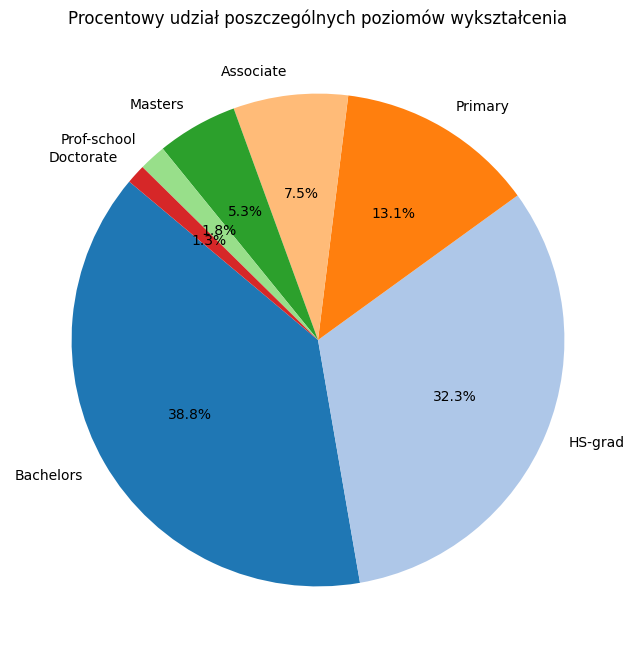

In [58]:
education_counts = incomes['education'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(education_counts, labels=education_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
plt.title('Procentowy udział poszczególnych poziomów wykształcenia')
plt.show()

In [59]:
training_cols = ['age', 'workclass', 'education', 'race', 'sex', 'hours-per-week', 'native-country', 'additional_money', 'income', 'fnlwgt']
training_incomes = incomes[training_cols]
categorical_cols = ['workclass', 'race', 'sex', 'native-country', 'education']
numeric = ['age', 'hours-per-week', 'additional_money', 'fnlwgt']

encoder = OneHotEncoder(sparse=False)
encoded_cols = pd.DataFrame(encoder.fit_transform(training_incomes[categorical_cols]), columns=encoder.get_feature_names_out(categorical_cols))
training_incomes = pd.concat([training_incomes.drop(columns=categorical_cols), encoded_cols], axis=1)

scaler = RobustScaler()
# scaler = StandardScaler()
# scaler = MinMaxScaler()

training_incomes[numeric] = scaler.fit_transform(training_incomes[numeric])

training_incomes.columns
X = training_incomes.drop('income', axis=1)
y = incomes['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [60]:
rand_for_1 = RandomForestClassifier(n_estimators=100, random_state=42, max_leaf_nodes=100, max_features="auto", bootstrap=False, min_samples_leaf=5, min_samples_split=3)

rand_for_1.fit(X_train, y_train)
rand_for_1.score(X_test, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


0.8399459525856774

In [61]:
print('Parametry wykorzystane dla modelu rand_for_1:\n')
pprint(rand_for_1.get_params())

Parametry wykorzystane dla modelu rand_for_1:

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': 100,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [63]:
y_pred_1 = rand_for_1.predict(X_test)
cm = confusion_matrix(y_test, y_pred_1)
cm

array([[6013,  201],
       [1102,  825]])

In [64]:
precision_score(y_test, y_pred_1, pos_label="<=50K")

0.8451159522136331

In [65]:
recall_score(y_test, y_pred_1, average="binary", pos_label="<=50K")

0.967653685226907

In [66]:
f1_score(y_test, y_pred_1, pos_label="<=50K")

0.902243229049441

In [72]:
rand_for_2 = RandomForestClassifier(n_estimators=1000, random_state=42, max_leaf_nodes=160)

rand_for_2.fit(X_train, y_train)
rand_for_2.score(X_test, y_test)

0.8410514678786389

In [73]:
print('Parametry wykorzystane dla modelu rand_for_2:\n')
pprint(rand_for_2.get_params())

Parametry wykorzystane dla modelu rand_for_2:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': 160,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [74]:
y_pred_2 = rand_for_2.predict(X_test)
cm = confusion_matrix(y_test, y_pred_2)
cm

array([[6009,  205],
       [1089,  838]])

In [75]:
precision_score(y_test, y_pred_2, pos_label="<=50K")

0.8465765004226543

In [76]:
recall_score(y_test, y_pred_2, average="binary", pos_label="<=50K")

0.9670099774702285

In [77]:
f1_score(y_test, y_pred_2, pos_label="<=50K")

0.9027944711538461

In [ ]:
rfc = RandomForestClassifier()

my_param_grid = {
    'bootstrap': [True, False],
    'n_estimators': [250, 500],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [2, 4],
    'min_samples_split': [5, 10]
}
gs = GridSearchCV(estimator = rfc, param_grid = my_param_grid, cv = 3, n_jobs = -1, verbose = 3)

In [ ]:
# GridSearch zajmuje bardzo dużo czasu

# gs.fit(X_train, y_train)

In [ ]:
# gs.best_params_

In [ ]:
# best_grid = gs.best_estimator_

<ipython-input-96-3c10d831ccae>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


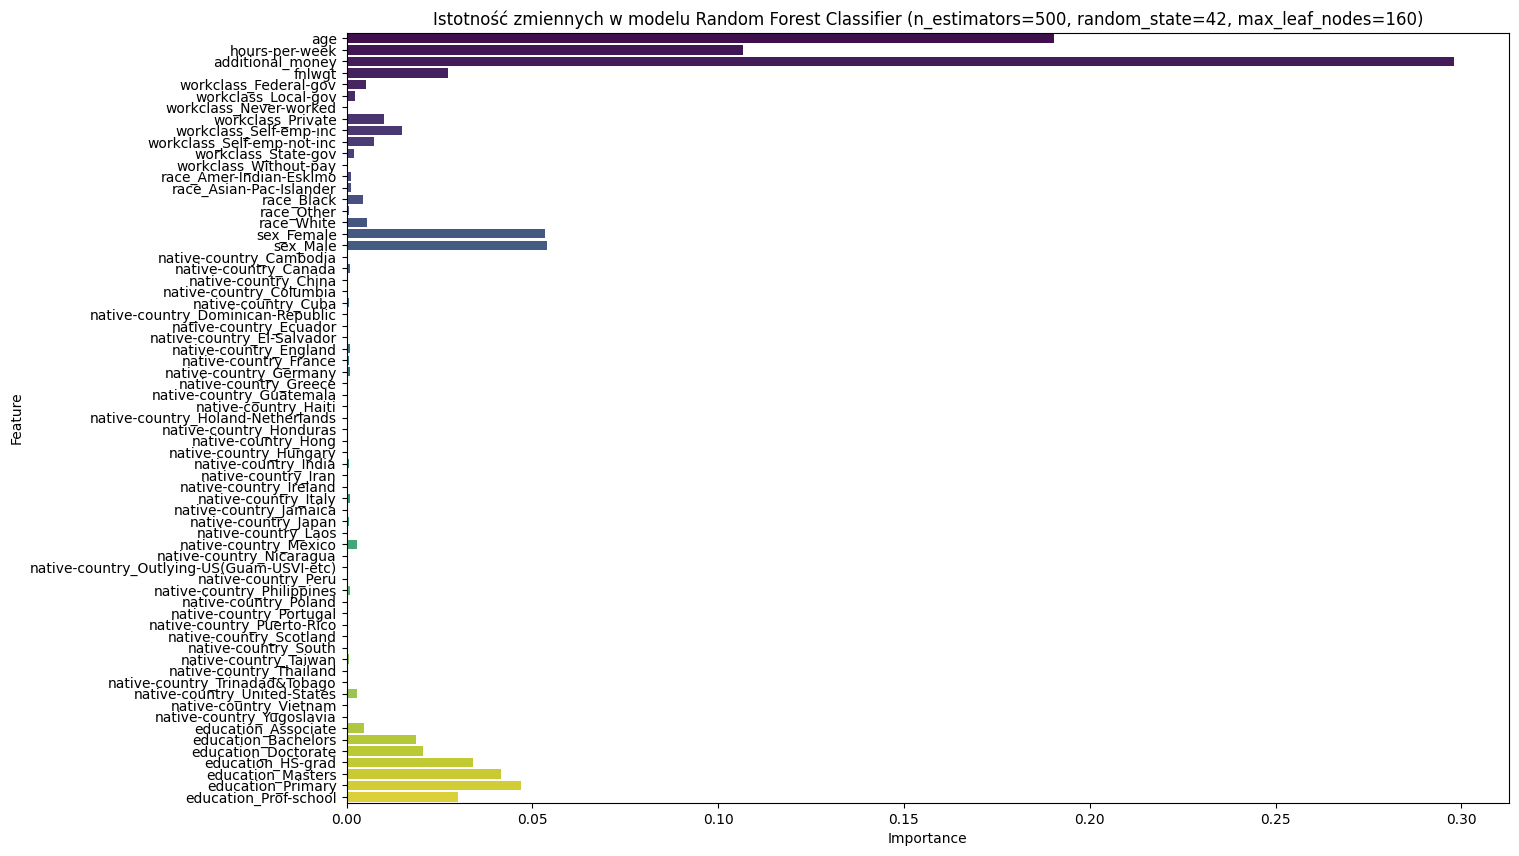

In [96]:
feature_importances = rand_for_2.feature_importances_

# DataFrame zawierający dane o istotności zmiennych
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df.sort_values("Importance", ascending=False)
feature_importance_df['Importance'].map(lambda x: f"{x:0.1f}")

# Wykres istotności zmiennych
plt.figure(figsize=(15, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Istotność zmiennych w modelu Random Forest Classifier (n_estimators=500, random_state=42, max_leaf_nodes=160)')
plt.show()

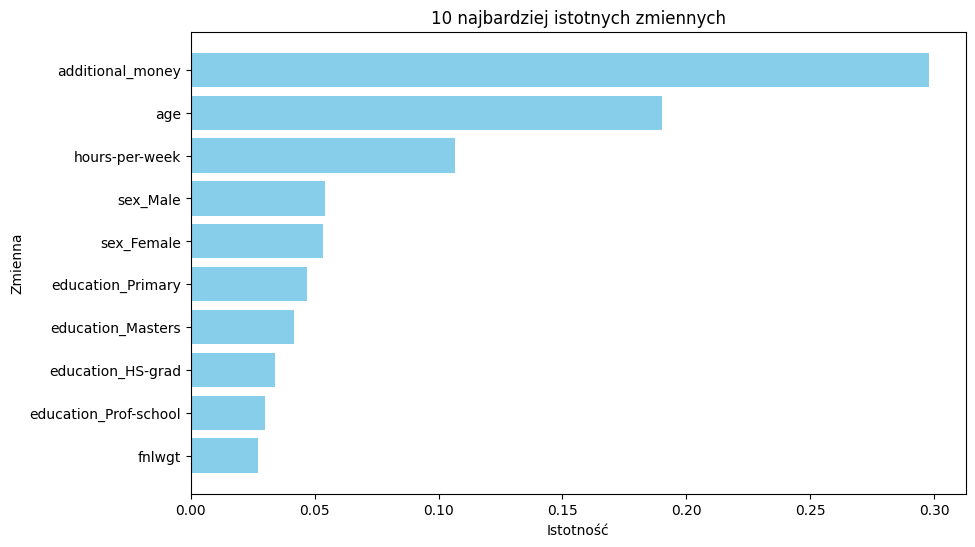

In [95]:
top_10 = feature_importance_df.sort_values("Importance", ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_10['Feature'], top_10['Importance'], color='skyblue')
plt.xlabel('Istotność')
plt.ylabel('Zmienna')
plt.title('10 najbardziej istotnych zmiennych')
plt.gca().invert_yaxis()

In [80]:
y_pred_proba = rand_for_2.predict_proba(X_test)[:, 1]
y_pred_proba
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=">50K")
roc_auc = roc_auc_score(y_test, y_pred_proba)

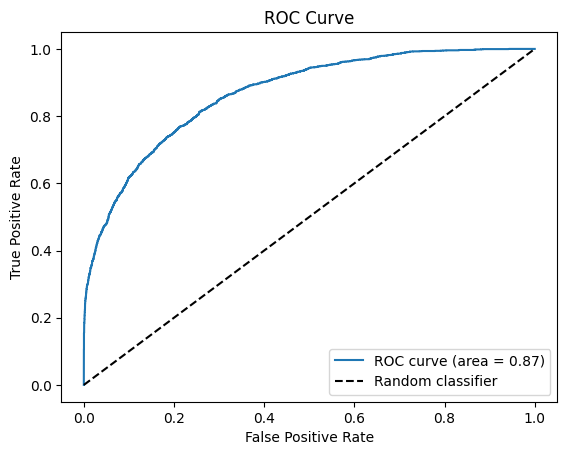

In [81]:
# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
# roc curve for tpr = fpr
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
y_probas_forest = cross_val_predict(rand_for_2, X_train, y_train, cv=3,
                                    method="predict_proba")
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train, y_scores_forest)